# SEN122A Statistical Analysis of Choice Behaviour 

## `Session Lab 03:`
## `Combining machine learning and discrete choice models`

**Delft University of Technology**<br>
**Q2 2024**<br>
**Instructor:** Sander van Cranenburgh<br>
**TA:**  Gabriel Nova <br>

### `Instructions`

**Lab sessions aim to:**<br>
* Show and reinforce how models and ideas presented in class are put to practice.<br>
* Help you gather hands-on machine learning skills.<br>

**Lab sessions are:**<br>
* Learning environments where you work with Jupyter notebooks and where you can get support from TAs and fellow students.<br> 
* Not graded and do not have to be submitted. 

### `Use of AI tools`
AI tools, such as ChatGPT and Co-pilot, are great tools to assist with programming. Moreover, in your later careers you will work in a world where such tools are widely available. As such, we **encourage** you to use AI tools **effectively**. However, be careful not to overestimate the capacity of AI tools! AI tools cannot replace you: you still have to conceptualise the problem, dissect it and structure it, to conduct proper analysis. We recommend being especially **reticent** with using AI tools for the more conceptual and reflective oriented questions. <br>
Futhermore, **be aware** that during the `partial exam`, you will not have acces to these tools (since internet access will be restricted).

### `Workspace set-up`


**Option 1: Anaconda**<br>

Uncomment the following lines if you are running this notebook on your local environment and want to use ANACONDA to set up your Python environment. 

Please ensure that you have activated an environment that meets the Python version described in the readme file (*3.12.7, 3.11.10, or 3.10.15*).

In [1]:
#!pip install -r requirements.txt

**Option 2: PIP**<br>
Uncomment the following cell if you are running this notebook on your local environment and want to use PIP to set-up your Python environment.

In [ ]:
#!pip install -r requirements.txt

**Option 3: Google Colab**<br>
Uncomment the following cell if you are running this notebook on Colab

In [ ]:
#!git clone https://github.com/SEN1221TUD/Q2_2024.git
#!mv "/content/Q2_2024/Lab_sessions/Lab_session_03/data" /content/data   

#!pip install biogeme
#import os
#os.kill(os.getpid(), 9)

### `Application: Modelling neighbourhood choices`

In this lab session, we will use neighbourhood location choice data of lab session 1: Stated Choice (SC) data, which was collected between 2017 and 2018 in four European cities: Hanover, Mainz, Bern, and Zurich. During this lab session, you will train a neural network and a hybrid choices model to uncover people's preferences over residential location choice attributes, such as the distance to the city centre and the share of foreigners in their neighbourhood. 

![sc](data/sc_experiment.png)


This time the emphesize is on the balance that the researcher must strike between behavioural rigour and model fit.
To do so, in this lab session you will (1) develop a multilayer perceptron model and (2) build a hybrid choice models.

**`Learning objectives lab session 03`**

After completing the following lab session you will be able to:
* Train a MultiLayer Perceptron on choice data


**`This lab consists of 3 parts and has 3 exercises`**

**Part 1**: Data preparation

**Part 2**: The linear-additive RUM-MNL model
- Excerise 1: "Willigness to pay for grocery stores"

**Part 3**: The MultiLayer Perceptron
- Excerise 2: "Training the MLP model"
- Excerise 3: "Adding the socio-demographic features"

#### `Import packages`

In [32]:
# Biogeme
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme import models
from biogeme.expressions import Beta, Variable, log

# Import required Python packages and modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Scikit-learn
from sklearn.preprocessing import StandardScaler

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Pandas setting to show all columns when displaying a pandas dataframe
pd.set_option('display.max_columns', None)

### `1. Load and explore the data set` <br>

 `i. Set up the workspace and load the database`

In [33]:
# Create that path to the data file
data_path = Path(f'data/choice_data_cleaned.dat')

# Load mode choice data into a pandas DataFrame
df = pd.read_csv(data_path, sep='\t')

# Show the column names 
print(df.columns)

Index(['ID', 'TASK_ID', 'STORES1', 'TRANSPORT1', 'CITY1', 'NOISE1', 'GREEN1',
       'FOREIGN1', 'STORES2', 'TRANSPORT2', 'CITY2', 'NOISE2', 'GREEN2',
       'FOREIGN2', 'STORES3', 'TRANSPORT3', 'CITY3', 'NOISE3', 'GREEN3',
       'FOREIGN3', 'RESPCITY', 'WOMAN', 'AGE', 'ENVCONC', 'EDUYEARS',
       'RESPFOREIGN', 'HOMEOWNER', 'CAROWNER', 'JOB', 'NONWESTERN', 'WESTERN',
       'CHOICE'],
      dtype='object')


**Description of variables**<br>

The number concatenated to the variable refers to the alternative. Hence, `STORES1` is the column containing the attribute levels of alternative 1 for attribute STORES.<br>

| Variable       | Description                                                    | Type/Levels |
|-------------|----------------------------------------------------------------|--------------|
| `ID`        | This is the ID number of the respondent                         | Integer      |
| `TASK_ID`   | This is the number of the respondent's task of choice           | Integer      |
| `STORES`    | Distance to grocery store in walking minutes                    | 2 Min., 5 Min., 10 Min., 15 Min.     |
| `TRANSPORT` | Distance to public transportation in walking minutes            | 2 Min., 5 Min., 10 Min., 15 Min.      |
| `CITY`      | Distance to city centre in km                                   | Below 1 km, 1 to 2 km, 3 to 4 km, over 4 km      |
| `NOISE`     | Street traffic noise                                            | 1 = None, 2 = Little, 3 = Meduim, 4 = High      |
| `GREEN`     | Green areas in residential area                                 | 1 = None, 2 = Few, 3 = Some, 4 = Many       |
| `FOREIGN`   | Share of foreigners in residential areas                        | 0.10, 0.20, 0.30, 0.40     |
| `CHOICE`    | Indicates the choice.                                           | Integer  |
| `RESPCITY`  | Indicates the city. 1 = Mainz, 2 = Hanover, 3 = Bern, 4 = Zurich| Categorical  |
| `WOMAN`     | Indicates 1 if woman and 0 otherwise                            | Binary       |
| `AGE`       | Age in years                                                    | Integer      |
| `ENVCONC`   | Environmental concern from 1 to 5, with 5 being the highest degree of concern | Ordinal |
| `EDUYEARS`  | Number of years in education                                    | Numeric      |
| `RESPFOREIGN`| 1 if the respondent is a foreigner, 0 otherwise                | Binary       |
| `HOMEOWNER` | Indicates 1 if the respondent is a home owner and 0 otherwise   | Binary       |
| `CAROWNER`  | Indicates 1 if the respondent is a car owner and 0 otherwise    | Binary       |
| `JOB`       | 1 if the respondent is working, 0 otherwise                     | Binary       |
| `NONWESTERN`| 1 if the respondent is non-western, 0 otherwise                 | Binary       |
| `WESTERN`   | 1 if the respondent is western, 0 otherwise                     | Binary       |

In [35]:
# Define the relevant features of the alternatives
features_alt =   ['STORES1', 'TRANSPORT1', 'CITY1', 'NOISE1', 'GREEN1', 'FOREIGN1', 
                  'STORES2', 'TRANSPORT2', 'CITY2', 'NOISE2', 'GREEN2', 'FOREIGN2',
                  'STORES3', 'TRANSPORT3', 'CITY3', 'NOISE3', 'GREEN3', 'FOREIGN3']

# Define the relevant socio-economic variables
sociovars = ['AGE','WOMAN','HOMEOWNER','CAROWNER','RESPCITY', 'JOB','NONWESTERN', 'WESTERN']

Recode categorical socio demographic variables

In [37]:
# Create a dataframe with the relevant socio demographic variables
df_sociovars  = df[sociovars].astype(int)

# Recode 'AGE' in three categorical levels.
df_sociovars.loc[(      df_sociovars['AGE'] < 25), 'AGE'] = 1
df_sociovars.loc[(25 <= df_sociovars['AGE']     ) &
                 (      df_sociovars['AGE'] < 60), 'AGE'] = 2
df_sociovars.loc[(60 <= df_sociovars['AGE']     ), 'AGE'] = 3

# Convert categorical variables to dummy variables using pd.get_dummies()
df_sociovars = pd.get_dummies(data = df_sociovars, prefix = sociovars, prefix_sep='_', columns = sociovars, drop_first = True, dtype=int)

# Create a list of the names of the socio demographic variables
features_socio = df_sociovars.columns.tolist()

# Show the first few rows of the dataframe
df_sociovars.head()

,AGE_2,AGE_3,WOMAN_1,HOMEOWNER_1,CAROWNER_1,RESPCITY_2,RESPCITY_3,RESPCITY_4,JOB_1,NONWESTERN_1,WESTERN_1
0,1,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,0
4,1,0,1,0,1,1,0,0,1,0,0


Finally, create the dataframe for training, containing the 'ID', 'CHOICE', attributes and dummy-coded socio-demographic variables

In [38]:
# Concatenate the socio demographic variables with the relevant features of the alternatives
df = pd.concat([df[['ID', 'CHOICE'] + features_alt], df_sociovars], axis=1)

# Show the first few rows of the dataframe
df.head()

,ID,CHOICE,STORES1,TRANSPORT1,CITY1,NOISE1,GREEN1,FOREIGN1,STORES2,TRANSPORT2,CITY2,NOISE2,GREEN2,FOREIGN2,STORES3,TRANSPORT3,CITY3,NOISE3,GREEN3,FOREIGN3,AGE_2,AGE_3,WOMAN_1,HOMEOWNER_1,CAROWNER_1,RESPCITY_2,RESPCITY_3,RESPCITY_4,JOB_1,NONWESTERN_1,WESTERN_1
0,2,1,10,5,1,2,2,0.4,15,10,2,3,3,0.1,2,15,4,4,4,0.2,1,0,0,0,0,0,1,0,0,0,0
1,2,2,15,5,4,4,1,0.1,2,10,5,1,2,0.2,5,15,1,2,3,0.3,1,0,0,0,0,0,1,0,0,0,0
2,2,3,10,15,1,3,1,0.4,15,2,2,4,2,0.1,2,5,4,1,3,0.2,1,0,0,0,0,0,1,0,0,0,0
3,2,2,15,15,5,4,4,0.4,2,2,1,1,1,0.1,5,5,2,2,2,0.2,1,0,0,0,0,0,1,0,0,0,0
4,3,2,15,5,5,1,3,0.4,2,10,1,2,4,0.1,5,15,2,3,1,0.2,1,0,1,0,1,1,0,0,1,0,0


`ii. Split the data in a test and train set`

In [39]:
# Set a seed for reproducibilty
np.random.seed(100)
df['draw']=float('nan')
for i in df['ID'].unique():
    num_obs = len(df.loc[df['ID']==i,'draw'])
    df.loc[df['ID']==i,'draw']= np.repeat(np.random.uniform(0,1,1),num_obs)

# Put 80% of the data in the training set and 20% in the test set
df_train = df.loc[df['draw']< 0.8,:].copy()
df_test  = df.loc[df['draw']>=0.8,:].copy()

# Number of observations in the training and test sets
num_obs_train = len(df_train)
num_obs_test  = len(df_test)

print(f'Number of individuals in the df_train and df_test: \t{df_train.ID.nunique()}  {df_test.ID.nunique()} ')
print(f'Number of observations in the df_train and df_test: \t{len(df_train)} {len(df_test)} ')

Number of individuals in the df_train and df_test: 	1825  423 
Number of observations in the df_train and df_test: 	7300 1692 


In [40]:
# Save a copy of the dataset for use in Lab 03EXTRA
df['train_set'] = df['draw']<0.8
df['test_set'] = df['draw']>=0.8

# Save the dataset to a file
df.to_csv('data/choice_data_cleaned_lab3E.dat', sep='\t', index=False)

`iii. Scaling the features`<br>
To efficiently train ANNs it strongly recommended to scale (a.k.a. normalise) the features. There are several ways to scale your data. A commonly used scaler of sk-learn is called 'StandardScaler'. This scaler normalises the variance and shift the location of the distribution to zero, see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [41]:
# Create X_train and X_test
x_train = df_train[features_alt + features_socio]
x_test  = df_test [features_alt + features_socio]

# Initialize the scaler object
scaler = StandardScaler()

# Fit and transform the training data
scaler = scaler.fit(df[features_alt + features_socio])

# Apply the fitted scaler to the  data sets
x_train_scaled = pd.DataFrame(scaler.transform(df_train[features_alt + features_socio]), columns=[features_alt + features_socio])
x_test_scaled =  pd.DataFrame(scaler.transform(df_test [features_alt + features_socio]), columns=[features_alt + features_socio]) # Apply the fitted scaler to the test data

print('Shape of x_train', x_train_scaled.shape)
print('Shape of x_test', x_test_scaled.shape)

# Create the target values
# Y must be a dummy coded array
y_train_dummy = pd.get_dummies(df_train['CHOICE']).values.astype(int)
y_test_dummy = pd.get_dummies(df_test['CHOICE']).values.astype(int)

Shape of x_train (7300, 29)
Shape of x_test (1692, 29)


`iv. Conversion to tensors`<br>
Many machine learning packages work with so-called tensors. Tensors are dedicated data structures to effciently train neural networks. Therefore, we need to convert the features and the target into a tensors datatype. In PyTorch, this is done with `torch.tensor()`.
 

In [42]:
# Create tensors for the train set
# In this case, we use only the features of the alternatives 'features_alt'
x_train_tensor = torch.tensor(x_train_scaled[features_alt].values, dtype=torch.float)
y_train_dummy_tensor = torch.tensor(y_train_dummy, dtype=torch.float)

# Create tensors for the test set
x_test_tensor = torch.tensor(x_test_scaled[features_alt].values, dtype=torch.float)
y_test_dummy_tensor = torch.tensor(y_test_dummy, dtype=torch.float)

# Print the shapes of the tensors   
print('Shape of x_train_tensor\t', x_train_tensor.shape)
print('Shape of x_test_tensor\t', x_test_tensor.shape)

Shape of x_train_tensor	 torch.Size([7300, 18])
Shape of x_test_tensor	 torch.Size([1692, 18])


## `2. Linear-additive RUM-MNL benchmark model`

`i. Model estimation`<br>
We first estimate our a linear-addtive RUM-MNL benchmark model.

In [43]:
# Convert pandas df into biogeme database
biodata_train = db.Database('neighbourhood_data_train', df_train)

In [44]:
# Create Biogeme variables

# Attributes of alternative 1
STORES1     = Variable('STORES1')
TRANSPORT1  = Variable('TRANSPORT1')
CITY1       = Variable('CITY1')
NOISE1      = Variable('NOISE1')
GREEN1      = Variable('GREEN1')
FOREIGN1    = Variable('FOREIGN1')

# Attributes of alternative 2    
STORES2     = Variable('STORES2')
TRANSPORT2  = Variable('TRANSPORT2')
CITY2       = Variable('CITY2')
NOISE2      = Variable('NOISE2')
GREEN2      = Variable('GREEN2')
FOREIGN2    = Variable('FOREIGN2')
    
# Attributes of alternative 3
STORES3     = Variable('STORES3')
TRANSPORT3  = Variable('TRANSPORT3')
CITY3       = Variable('CITY3')
NOISE3      = Variable('NOISE3')
GREEN3      = Variable('GREEN3')
FOREIGN3    = Variable('FOREIGN3')

# choice
CHOICE      = Variable('CHOICE')

In [45]:
# Give a name to the model    
model_name = 'Linear-additive RUM-MNL'

# Define the model parameters, using the function "Beta()", in which you must define:
B_stores    = Beta('B_stores'   , 0, None, None, 0)
B_transport = Beta('B_transport', 0, None, None, 0)
B_city      = Beta('B_city'     , 0, None, None, 0)
B_noise     = Beta('B_noise'    , 0, None, None, 0)
B_green     = Beta('B_green'    , 0, None, None, 0)
B_foreign   = Beta('B_foreign'  , 0, None, None, 0)

# Define the utility functions
V1 = B_stores * STORES1 + B_transport * TRANSPORT1 + B_city * CITY1 + B_noise * NOISE1 + B_green * GREEN1 + B_foreign * FOREIGN1
V2 = B_stores * STORES2 + B_transport * TRANSPORT2 + B_city * CITY2 + B_noise * NOISE2 + B_green * GREEN2 + B_foreign * FOREIGN2
V3 = B_stores * STORES3 + B_transport * TRANSPORT3 + B_city * CITY3 + B_noise * NOISE3 + B_green * GREEN3 + B_foreign * FOREIGN3

# Associate utility functions with alternatives
V = {1: V1, 2: V2, 3: V3}    

# Associate the availability conditions with the alternatives
AV = {1: 1, 2: 1, 3: 1} 

# Definition of the model. This is the contribution of each observation to the log likelihood function.
prob = models.logit(V, AV, CHOICE)

# Create the Biogeme object
biogeme = bio.BIOGEME(biodata_train, log(prob))

# Set reporting levels
biogeme.generate_pickle = False
biogeme.generate_html = False
biogeme.saveIterations = False
biogeme.modelName = model_name

# Compute the null loglikelihood for reporting
biogeme.calculate_null_loglikelihood(AV)

# Estimate the parameters
results = biogeme.estimate()
print(results.short_summary())

# Get the results in a pandas table
beta_hat = results.get_estimated_parameters()
print(beta_hat)

Results for model Linear-additive RUM-MNL
Nbr of parameters:		6
Sample size:			7300
Excluded data:			0
Null log likelihood:		-8019.87
Final log likelihood:		-6511.05
Likelihood ratio test (null):		3017.64
Rho square (null):			0.188
Rho bar square (null):			0.187
Akaike Information Criterion:	13034.1
Bayesian Information Criterion:	13075.47

                Value  Rob. Std err  Rob. t-test  Rob. p-value
B_city      -0.163189      0.009138   -17.857614           0.0
B_foreign   -1.223319      0.124067    -9.860112           0.0
B_green      0.412454      0.012934    31.889392           0.0
B_noise     -0.433723      0.011975   -36.219826           0.0
B_stores    -0.033651      0.002956   -11.383961           0.0
B_transport -0.073372      0.002823   -25.989810           0.0


`ii. Compute the LL of the estimated model on the test set`

In [46]:
# Create the biogeme simulation object
biodate_test = db.Database('Neighbourhood_data_test', df_test)

# Simulate th choice probability for the MNL model on the test set
dict2simulate = {'prob_chosen':prob}

# Create the Biogeme simulation object
biosim = bio.BIOGEME(biodate_test,dict2simulate)
simulated_probs = biosim.simulate(the_beta_values=results.get_beta_values())

# Calculate the log-likelihood of the MNL model on the test set and print it
LL_MNL_test = np.log(simulated_probs['prob_chosen']).sum()
print(f'LL MNL test: {LL_MNL_test:0.2f}')

LL MNL test: -1472.97


## ``Exercise 1: Willingness to pay for grocery stores``

`A` Calculate the willingness to pay reduce the number of walking minutes to the grocery stores by one minute, expressed in terms of walking minutes to the public transport. Use formula:<br><br>
$WTP = \frac{\beta_{stores}}{\beta_{transport}}$<br><br>
`B` Interpret this result. What do people find more important; walking minutes to grocery stores or walking minutes to public transport?

#### `Answers`

In [47]:
# A
WTP_MNL = beta_hat.loc['B_stores']['Value']/beta_hat.loc['B_transport']['Value']
print(f'\nWilligness to pay to reduce one minute of walking time to the grocery store is: {WTP_MNL:.2f} walking minutes to the public transport')

# B
print('\nDistance to the public transport almost twice as important than distance to the grocery store because the WTP is < 1')


Willigness to pay to reduce one minute of walking time to the grocery store is: 0.46 walking minutes to the public transport

Distance to the public transport almost twice as important than distance to the grocery store because the WTP is < 1


## `3. The MLP model`

A MultiLayer Perceptron (MLP) is a neural network widely used in machine learning because of its ability to learn complex patterns. It is composed of hidden layers with neurons and activation functions. <br>

For example, in the following image, we can see an input layer with 8 features, two hidden layers with each 10 hidden nodes, and the output layer with 3 output classes:<br>

<p align="center\">
<img width="800" src="assets/MLP.png">
</p> 

`i. Define MLP model`<br>
We will create a fully connected neural network with two hidden layers. To do so, we create a new class using PyTorch's nn.Module. We define how the object is initialised.In this case, we will have an input layer of size `input_size`, two hidden layers with sizes `hidden_size1` and `hidden_size2` respectively, and an output layer of size `output_size`. Additionally, we define the forward function. The forward function takes an input value `x`, passes it through the network layers, while applying activation functions. It outputs the utilities of each alternative `V`.

In [48]:
# Fully connected neural network with two hidden layer
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x)) # tanh activation function for the 1st layer
        x = torch.tanh(self.fc2(x)) # tanh activation function for the 2nd layer
        V = self.fc3(x)             # linear activation function for the output layer

        return V                    # return the "Utility" of each alternative

`ii. Create DataLoaders`<br>
A PyTorch Dataloader object effciently handles the data flow during training and testing. It creates the minibatches, and ensures that are instances of the data are depleted each epoch. <br>We create a DataLoader for both the train and test data sets. 

In [49]:
# Create a DataLoader for the train set
dataset_train = TensorDataset(x_train_tensor, y_train_dummy_tensor)
train_loader = DataLoader(dataset_train, batch_size=250, shuffle=True)

# Create a DataLoader for the test set
dataset_test = TensorDataset(x_test_tensor, y_test_dummy_tensor)
test_loader = DataLoader(dataset_test, batch_size=len(x_test_tensor), shuffle=True)

`iii. Define functions`<br>
We define the the following functions:
1. a function to evaluate the model performance during training
2. a function to visualise the training progress
3. a function to inspect the model object

This function is used to evaluate the performance on the test data after each epoch.

In [50]:
def evaluate(model, criterion, data_loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    return total_loss

This function visualises the training progress. We call this function after the training is finished.

In [51]:
def show_loss_plot(train_losses, test_losses, num_obs_train, num_obs_test):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(np.array(train_losses)/num_obs_train, label='Training Loss')
    ax.plot(np.array(test_losses)/num_obs_test,   label='Test Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.show()

This function allows us to inspect the created model architecture. It lists the number of weights per layer, and their input and output sizes. 

In [52]:
def print_model_summary(model):
    total_params = 0
    print(f"=== Model Summary ===")
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_params = param.numel()
            total_params += num_params
            print(f"Layer: {name:20}|\t Weights: {num_params}")

    print(f"\nTotal trainable Weights: {total_params}")

    print("\n=== Layers ===")
    for layer in model.children():
        print(layer)

`iv. Create the MLP object`<br>

In [53]:
# Define the dimensions of the MLP
input_size   = x_train_tensor.size()[1]  # Number of input features
hidden_size1 = 20#0                        # Number of units in first hidden layer
hidden_size2 = 20#0                        # Number of units in second hidden layer
output_size  = 3                         # Number of output classes (determined by the number of alternatives)
print(f' input_size = {input_size}, hidden_size1 = {hidden_size1}, hidden_size2 = {hidden_size2}, output_size = {output_size}')

 input_size = 18, hidden_size1 = 20, hidden_size2 = 20, output_size = 3


In [54]:
# Invoke the MLP model
model = MLP(input_size, hidden_size1, hidden_size2, output_size)

# Print the model architecture
print_model_summary(model)

=== Model Summary ===
Layer: fc1.weight          |	 Weights: 360
Layer: fc1.bias            |	 Weights: 20
Layer: fc2.weight          |	 Weights: 400
Layer: fc2.bias            |	 Weights: 20
Layer: fc3.weight          |	 Weights: 60
Layer: fc3.bias            |	 Weights: 3

Total trainable Weights: 863

=== Layers ===
Linear(in_features=18, out_features=20, bias=True)
Linear(in_features=20, out_features=20, bias=True)
Linear(in_features=20, out_features=3, bias=True)


Define settings for the training

`v. Train the MLP model`<br>
Finally, we are ready to train the model!

In [55]:
nEpoch = 500  # Set the number of epochs
lr = 0.0001  # Set the learning rate
status = 10  # Print status every 'status' epochs
patience = 5  # Number of epochs to wait before early stopping

Epoch [    1/500], Train Loss: 7965.256, Test Loss: 1836.607
Epoch [   10/500], Train Loss: 7431.839, Test Loss: 1713.368
Epoch [   20/500], Train Loss: 6750.208, Test Loss: 1553.916
Epoch [   30/500], Train Loss: 6357.026, Test Loss: 1459.596
Epoch [   40/500], Train Loss: 6189.051, Test Loss: 1418.405
Epoch [   50/500], Train Loss: 6120.141, Test Loss: 1401.700
Epoch [   60/500], Train Loss: 6090.310, Test Loss: 1394.954
Epoch [   70/500], Train Loss: 6075.886, Test Loss: 1391.769
Epoch [   80/500], Train Loss: 6067.653, Test Loss: 1389.749
Epoch [   90/500], Train Loss: 6062.271, Test Loss: 1388.734
Epoch [  100/500], Train Loss: 6058.379, Test Loss: 1387.761
Epoch [  110/500], Train Loss: 6055.516, Test Loss: 1387.259
Epoch [  120/500], Train Loss: 6053.473, Test Loss: 1386.862
Early stopping at epoch 123

Training finished.	Train Loss: 6053.136, Test Loss: 1386.848


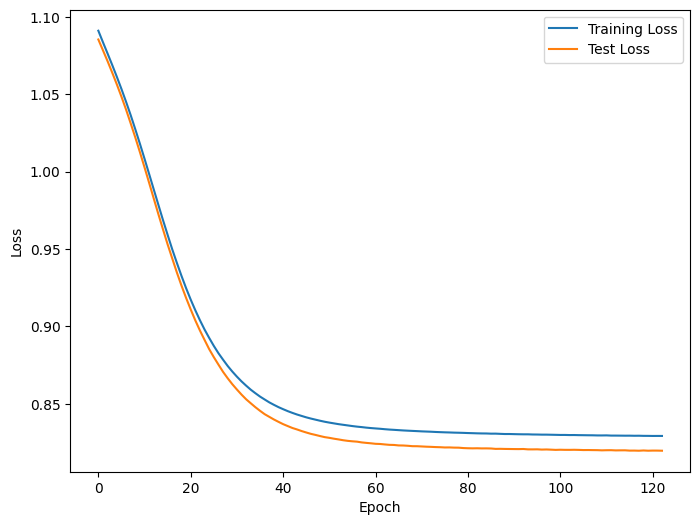

In [56]:
do_training = True
if do_training == True:

    # Define the model, loss function and optimizer
    
    optimizer = optim.Adam(params=model.parameters(), lr=lr,  betas=(0.9, 0.999), eps=1e-07, weight_decay=0)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')

    # Define lists to store losses
    train_losses = []
    test_losses = []

    # Initialize early stopping counter 
    counter = 0
    best_loss = np.inf  # Set initial loss to infinity

    # Training loop
    for epoch in range(nEpoch):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)   

            # Compute the loss
            loss = loss_fn(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss += loss.item() # Log-likelihood on the training set

        # Evaluate on the test set
        test_loss = evaluate(model, loss_fn, test_loader) # Log-likelihood on the test set

        # Print status every 'status' epochs or epoch 0
        if epoch == 0 or (epoch + 1) % status == 0:
            print(f'Epoch [{epoch+1:5.0f}/{nEpoch}], Train Loss: {running_loss:0.3f}, Test Loss: {test_loss:0.3f}')

        # Store losses
        train_losses.append(running_loss)
        test_losses.append(test_loss)

        # Implement early stopping
        if test_loss < best_loss:
            best_loss = test_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
            
    print(f'\nTraining finished.\tTrain Loss: {running_loss:0.3f}, Test Loss: {test_loss:0.3f}')
    show_loss_plot(train_losses, test_losses,num_obs_train, num_obs_test)

## `Exercise 2: Training the MLP model`

`A` Compare the performance on the test set of the MLP with the benchmark MNL. Has it (much) improved? What does this tell us? <br>
`B` Retrain the MLP using the following architectures: {hidden_size1,hidden_size2} = {1,1}, {3,3}, {1,20}, {20,1}, {20,3}, {20,20}<br>
`C` Does increasing the number of nodes lead to better generalisation performance (i.e. higher LL_test)? What is happening?<br>
`D` Explain why {1,1} and either {20,1} and {1,20} lead to a poor performance. <br>
`E` Retrain your model with a smaller and larger learning rate: lr = 0.01 and lr = 0.00001. Use {hidden_size1,hidden_size2} = {5,5}. Explain what is happening.

#### `Answers`


`A` The MLP improves the model fit by  almost 100 LL points. This is a lot. It tells the linear-additive utility assumption is too restrictive.<br>

`B`<br>
{1,1} gives a poor generalisation performance: LL = ~-1670<br>
{3,3} gives an okay generalisation performance: LL = ~-1470<br>
{1,20} gives a poor generalisation performance: LL = ~-1630<br>
{20,1} gives an poor generalisation performance: LL = ~-1670<br>
{20,3} gives an okay generalisation performance: LL = ~-1457<br>
{20,20} gives an okay generalisation performance: LL = ~-1455<br>

`C` Increasing it from {1,1} to {3,3} increase the perf on LL_test. But {20,20} does not help it to further increase. <br>

`D` All information is squashed to one node. Therefore, the models is not able to associate features to alternatives, leading to a poor performance.<br>

`E` A large lr leads to quick training. But instability near the convergence. A small lr leads to slow training. The model was not nearly converged when the maximum number of training epochs was reached. 

## `Exercise 3: Adding the socio-demographic features`

In Section 1 under `iv. Conversion to tensors` we choose to use only the features of the alternatives as inputs (i.e. `features_alt`), while in lab session 1 we saw that at least gender (`WOMAN`) and the residential city (`RESPCITY`) have some eplanatory power.<br>

`A` Modify the code in this cell so that also these socio demographic features are used. Then, retrain the MLP.<br>
`B` Perhaps counter to your expectations, the model performance does not increase much. 
What does this tell us about: 
1. the explanatory power of socio-demographics to the residential location choice, and 
2. the ability of MLP models to learn subtle interaction effects? 

#### `Answers`


`A.i` Redefine the tensor and dimension of the MLP model to include the new variables.  

In [57]:
do_exercise3 = False
if do_exercise3 == True:
    #### Recreate tensors for the train set ####

    # In this case, we use the characteristics of the alternatives 'features_alt', WOMAN and RESPCITY.
    selected_features = features_alt + ['WOMAN_1', 'RESPCITY_2', 'RESPCITY_3', 'RESPCITY_4']

    x_train_tensor = torch.tensor(x_train_scaled[selected_features].values, dtype=torch.float)
    y_train_dummy_tensor = torch.tensor(y_train_dummy, dtype=torch.float)

    x_test_tensor = torch.tensor(x_test_scaled[selected_features].values, dtype=torch.float)
    y_test_dummy_tensor = torch.tensor(y_test_dummy, dtype=torch.float)

    #### Recreate DataLoader ####
    dataset_train = TensorDataset(x_train_tensor, y_train_dummy_tensor)
    train_loader = DataLoader(dataset_train, batch_size=250, shuffle=True)

    dataset_test = TensorDataset(x_test_tensor, y_test_dummy_tensor)
    test_loader = DataLoader(dataset_test, batch_size=len(x_test_tensor), shuffle=True)

    #### Redefine the dimension of the MLP  ####
    input_size   = x_train_tensor.size()[1]  # Number of input features
    hidden_size1 = 20                        # Number of units in first hidden layer
    hidden_size2 = 20                        # Number of units in second hidden layer
    output_size  = 3                         # Number of output classes (determined by the number of alternatives)

    model = MLP(input_size, hidden_size1, hidden_size2, output_size)

`A.ii` Retrain the MLP model using the same cell as above:  <br>

Train Loss: 6376.556, Test Loss: 1454.600<br> 


`B.1` The slight improvement in the performance of the MLP model by including the WOMAN and RESPCITY variables suggests that these socio-demographic factors may not be key determinants of residential choice. <br>

`B.2` Furthermore, this suggests that MLP models may have difficulty capturing small relationships between factors, which highlights the importance of adequately considering the features included in the model estimation. 